We will use MCMC to infer the $p$ parameter of a binomial distribution. This is more to take PyMC3 for a spin than to achieve deep mathematical insight :p

In [1]:
import numpy as np
from scipy import stats
import pymc3

import matplotlib.pyplot as plt
plt.style.use("ggplot")

First set up some data drawn from a binomial distribution (feel free to play with the params). From this point on, we will hide the true value of $p$ from our models.

In [2]:
n = 1000
p = 0.5

data = np.random.binomial(n,p)
print(data)

475


Set up our prior distribution over $p$. We will a beta distribution with $\alpha = \beta = 1$ to signify that we don't know anything about $p$ yet (so our beliefs are uniform). Here we just plot the distribution to sanity check the params; PyMC3 will take care of the representations within the context of a model later.

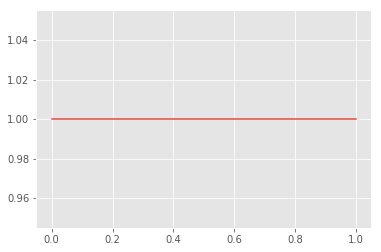

In [19]:
alpha = 1
beta = 1

def plot_distribution(dist):
    x = np.linspace(0, 1, 100)
    y = np.apply_along_axis(dist.pdf, 0, x)
    _ = plt.plot(x, y)
    
prior = stats.beta(alpha, beta)
plot_distribution(prior)

So we have a binomial distribution with an unknown parameter $p$ about which we have no prior knowledge, and a bunch of observations sampled from this distribution. Let's run the Metropolis algorithmn on this setup.

In [4]:
iterations = 100000

model = pymc3.Model()
with model:
    theta = pymc3.Beta("theta", alpha=alpha, beta=beta) # Let our prior over p be a 'free' RV named theta. This *happens* to also be a conjugate prior so we do not need MCMC, but we will use it anyways
    likelihood = pymc3.Binomial("likelihood", n=n, p=theta, observed=data) # The likelihood function is an 'observed' random variable with fixed data
    
    initial_guess = pymc3.sample()    
    step = pymc3.Metropolis()
    trace = pymc3.sample(iterations, step, initial_guess, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2995.62draws/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 402000/402000 [01:10<00:00, 5728.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


We can see what the model thinks about $p$ by sampling the generated Markov Chains and seeing where they spent most of their time.

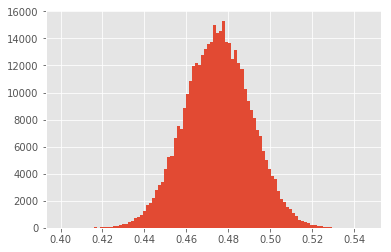

In [15]:
_ = plt.hist(trace["theta"], 100)

Of course, the beta distribution is a conjugate prior to the Bernoulli/binomial distribution, so we could have just used Bayesian inference to estimate the probability of success given some data.

Skipping over the derivation, if we plug a beta likelihood function and beta distribution into Bayes' Rule with our observed data given as $N$ total trials with $z$ successful outcomes, the posterior is given as:

$beta(\theta | z + \alpha, N - z + \beta)$

Let's see if we get a similar result with the analytical solution.

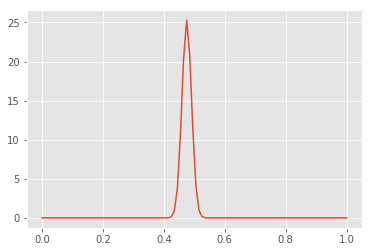

In [20]:
posterior = stats.beta(data + alpha, n - data + beta)
plot_distribution(posterior)